<a href="https://colab.research.google.com/github/sujin-create/hodlhodl/blob/Sentiment-analysis/Reddit%20sentiment%20analysis%20with%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis with BERT
Reddit Bitcoin 카테고리의 daily discussion 댓글을 날짜 별로 크롤링하여 감정 분류를 진행한다.
* Comments crawling: Using praw API
* Sentiment analysis: BERT model을 전이학습한 후 크롤링한 댓글을 Test하여 감정 분류 결과를 도출함. Negative는 -1, Netural은 0, Positive는 1의 가중치를 부여하여 K 가중치 값을 계산함. K 가중치 값은 비트 코인 주가 예측에 활용할 예정.

> 아래 코드를 직접 실행시키는 경우 시간 관계상 훈련된 모델을 다운받아 테스트를 진행해도 됨




## Crawling comments of Reddit 'Bitcoin' Category Daily Discussion 

In [ ]:
!pip install praw

In [ ]:
import praw
reddit = praw.Reddit(
    client_id="Your_client_id",
    client_secret="Your client_secret",
    user_agent="Your user_agent",
    username="Your username",
    password="Your password"
)

In [ ]:
subreddit = reddit.subreddit('bitcoin')   # subreddit: 토픽, submission: 게시글, comment: 댓글
submissionID = []   # Daily Discussion의 게시글 ID를 저장

for submission in subreddit.hot(limit=1):   # Daily discussion 2개가 (어제, 오늘) 동시에 있는 경우 확인하기
  submissionID.append(submission.id)
  print('submission title: ', submission.title, '\nSubmission ID =', submission.id)

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



submission title:  Daily Discussion, May 06, 2022 
Submission ID = ujg2qw


In [ ]:
# Daily discussion ID를 활용해 게시글에 대한 정보 출력
comments_all = []   # 전체 댓글을 저장
dailydiscussion = reddit.submission(id = submissionID[0])
dailydiscussion.comments.replace_more(limit = None)

for comments in dailydiscussion.comments.list():
    comments_all.append(comments.body)
print('총 댓글 개수: ', len(comments_all))

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



총 댓글 개수:  202


In [ ]:
comments_all

["If I go out and buy a $5 wrench and attack myself with it, how long do you think it will take until I'm immune?",
 'Please remain seated, seatbelts on, we are experiencing some slight turbulence. In the meantime please peruse the inflight magazine were you’ll find some excellent offers, as fiat crashes violently into the sea.',
 'Didn’t sell a sat.',
 'Holding and bought some extra on top of my dca 🤑',
 "I've been waiting for BTC to drop, yesterday loaded my first one.",
 'jobs report is positive, why we dumping',
 "Not sure about anyone else, but I couldn't care less about the current market conditions.   In the long run this is all just noise.  It's silly that people are upset.",
 'If you just buy now and hold until at least the year after the next halving, any inflation hike on whatever products or services will be a laughable moment for you.',
 'Any other year, BTC would be at like $8k right now.',
 'Unemployment report out in 15 mins.  That’ll probably be the reason for todays m

In [ ]:
# dataframe으로 변환 후 날짜, 댓글, 분석 결과(분석하면)를 csv 파일로 저장함
import pandas as pd
from datetime import datetime, timedelta

date = datetime.today().strftime('%Y-%m-%d')  # 날짜 출력
results = []  # 감정 분석 후 결과 저장

data = {
    'date':date,
    'comments': comments_all,
}

df_comments = pd.DataFrame(data)

In [ ]:
df_comments

,date,comments
0,2022-05-06,If I go out and buy a $5 wrench and attack mys...
1,2022-05-06,"Please remain seated, seatbelts on, we are exp..."
2,2022-05-06,Didn’t sell a sat.
3,2022-05-06,Holding and bought some extra on top of my dca 🤑
4,2022-05-06,"I've been waiting for BTC to drop, yesterday l..."
...,...,...
197,2022-05-06,This daily thread can be so cringe lol
198,2022-05-06,This sub in a nutshell
199,2022-05-06,>No it doesn't. I'm gonna buy more whatever th...
200,2022-05-06,I'm not sure to be honest. For a regular Bitco...


## BERT 모델 학습 및 테스트를 통한 감정 분석

In [ ]:
!nvidia-smi   # GPU 상태 모니터링

Fri May  6 17:18:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 필요한 라이브러리 설치

In [ ]:
!pip install -q -U watermark
!pip install transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.11.0+cu113
transformers: 4.18.0



In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 학습용 데이터셋 다운로드
* 데이터 셋: review comments of Google application


> 감정 분류 모델의 일반적인 Open dataset은 뉴스 기사 등 문어체로 작성된 문장들이 대부분임. Google App store의 고객 리뷰 데이터는 구어체로 이루어져 있으며, 이는 본 프로젝트에서 사용하는 Reddit comments 데이터와 유사한 성격을 가짐. 따라서 해당 데이터셋을 이용해 BERT 모델을 학습시켜 테스트 데이터셋에 대한 성능을 향상시키고자 함. 
* 추후 더욱 적절한 데이터셋을 발견하면, 이를 반영하여 모델을 재학습시키고자 함.



In [ ]:
# 데이터셋 다운로드
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 77.1MB/s]


In [ ]:
# 데이터셋 다운로드
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 137MB/s]


In [ ]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df.shape  # 데이터셋 size 확인

(15746, 11)

In [ ]:
df.info()   # 데이터셋 정보 (type)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

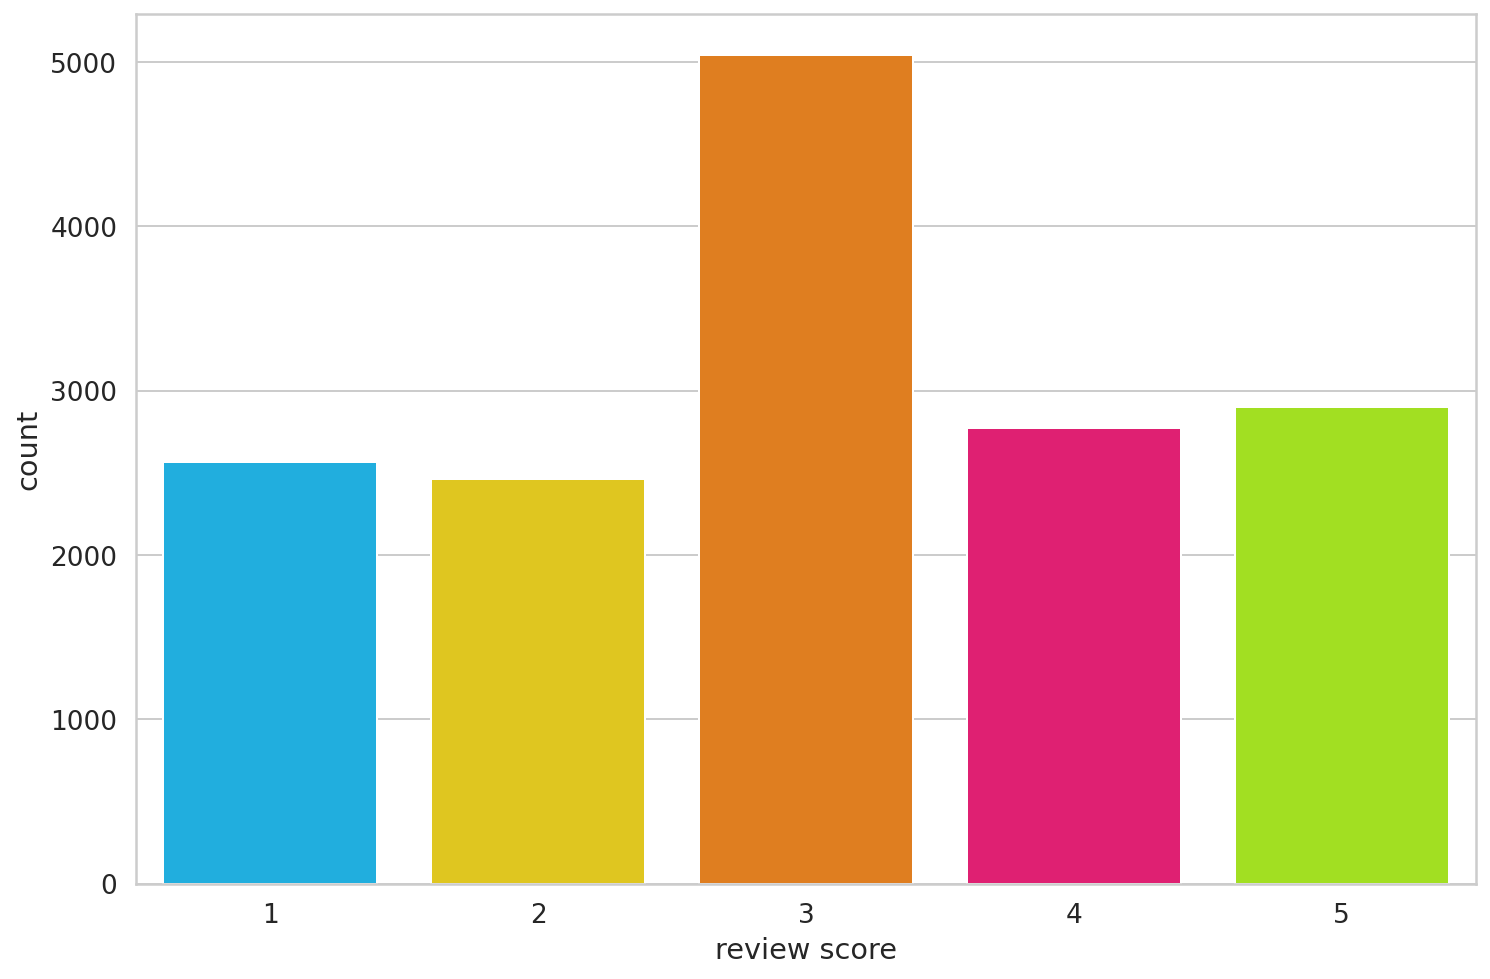

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score')    # 별점 당 개수 출력

In [ ]:
# 1~5 까지의 별점을 positive, netural, negative로 총 3가지 카테고리로 나눔
# positive, netural, negative 세 가지 카테고리로 나누어 학습하는 것이 Sentiment analysis 모델의 특징
# 감정을 더욱 세분화해 학습시키는 것은 emotion analysis 분야이며, 본 프로젝트에서 필요한 K 가중치 값을 구하기 위해서는 sentimental analysis 모델을 사용해야 함.

def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


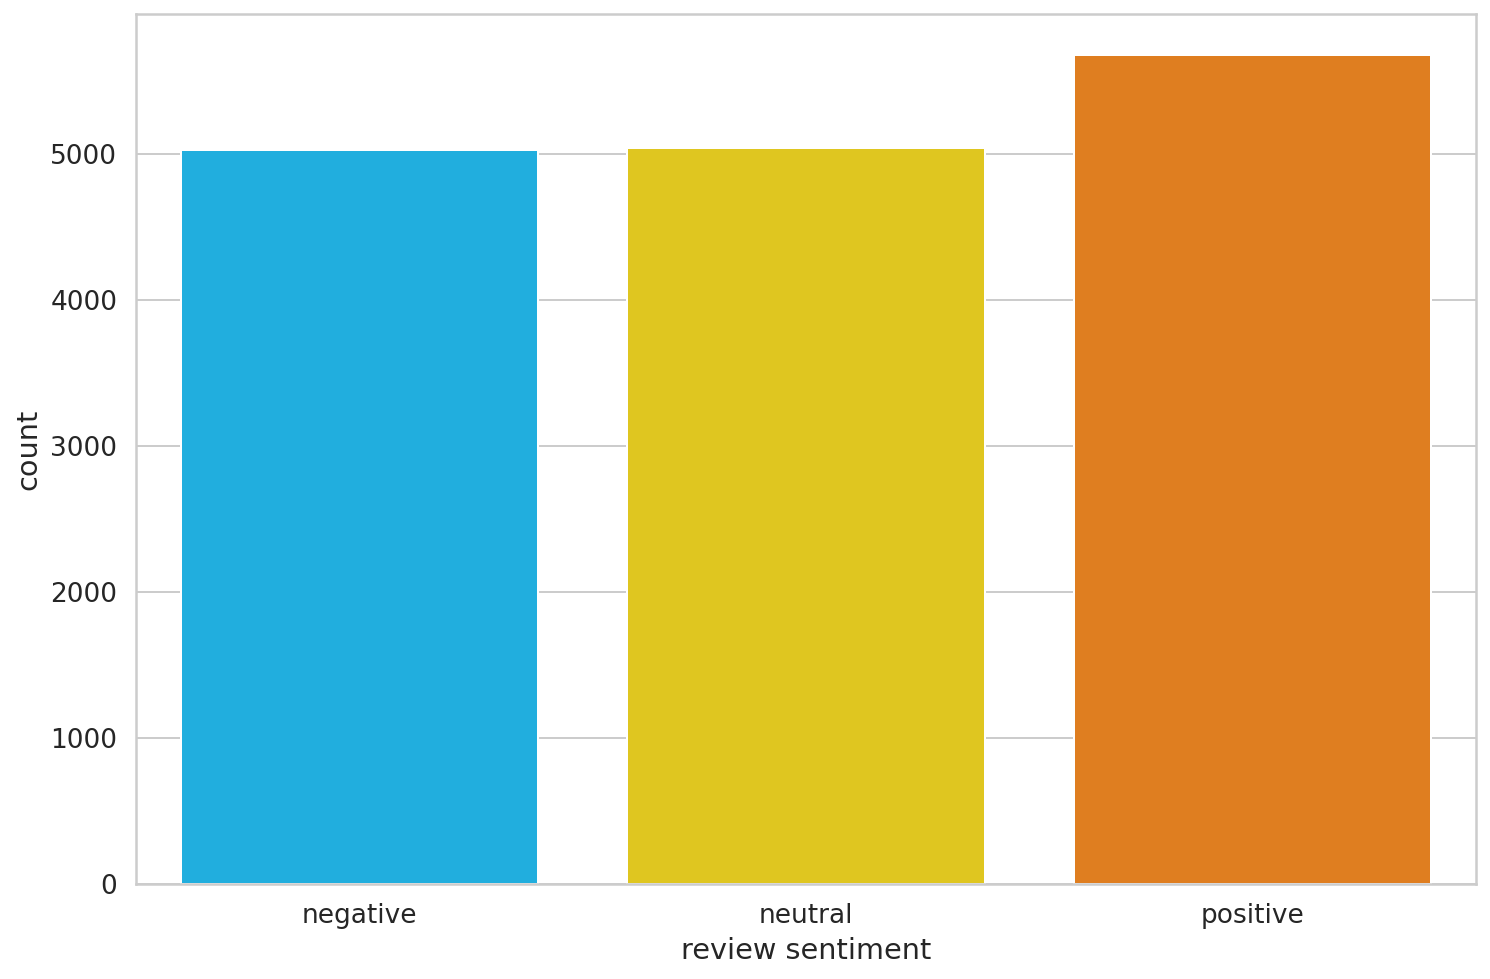

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

# 감정을 세 가지 분류로 나눔

### 데이터 전처리 (Data Preprocessing)



In [ ]:
# 데이터 전처리에 필요한 tokenizer 모델 다운로드
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# 예시 문장으로 전처리 진행 후 결과 확인
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
# special token들은 따로 토큰화 진행. [SEP], [CLS], [PAD], [UNK]
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
# encoding 진행

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  # pad_to_max_length=True,
  padding=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

17


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

17


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
# sample_text 에 대한 토큰화 결과 확인
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]']

### Sequence Length 선택
BERT 모델은 fixed-length sequences를 가지며, 이를 효과적으로 선택해야 함.

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


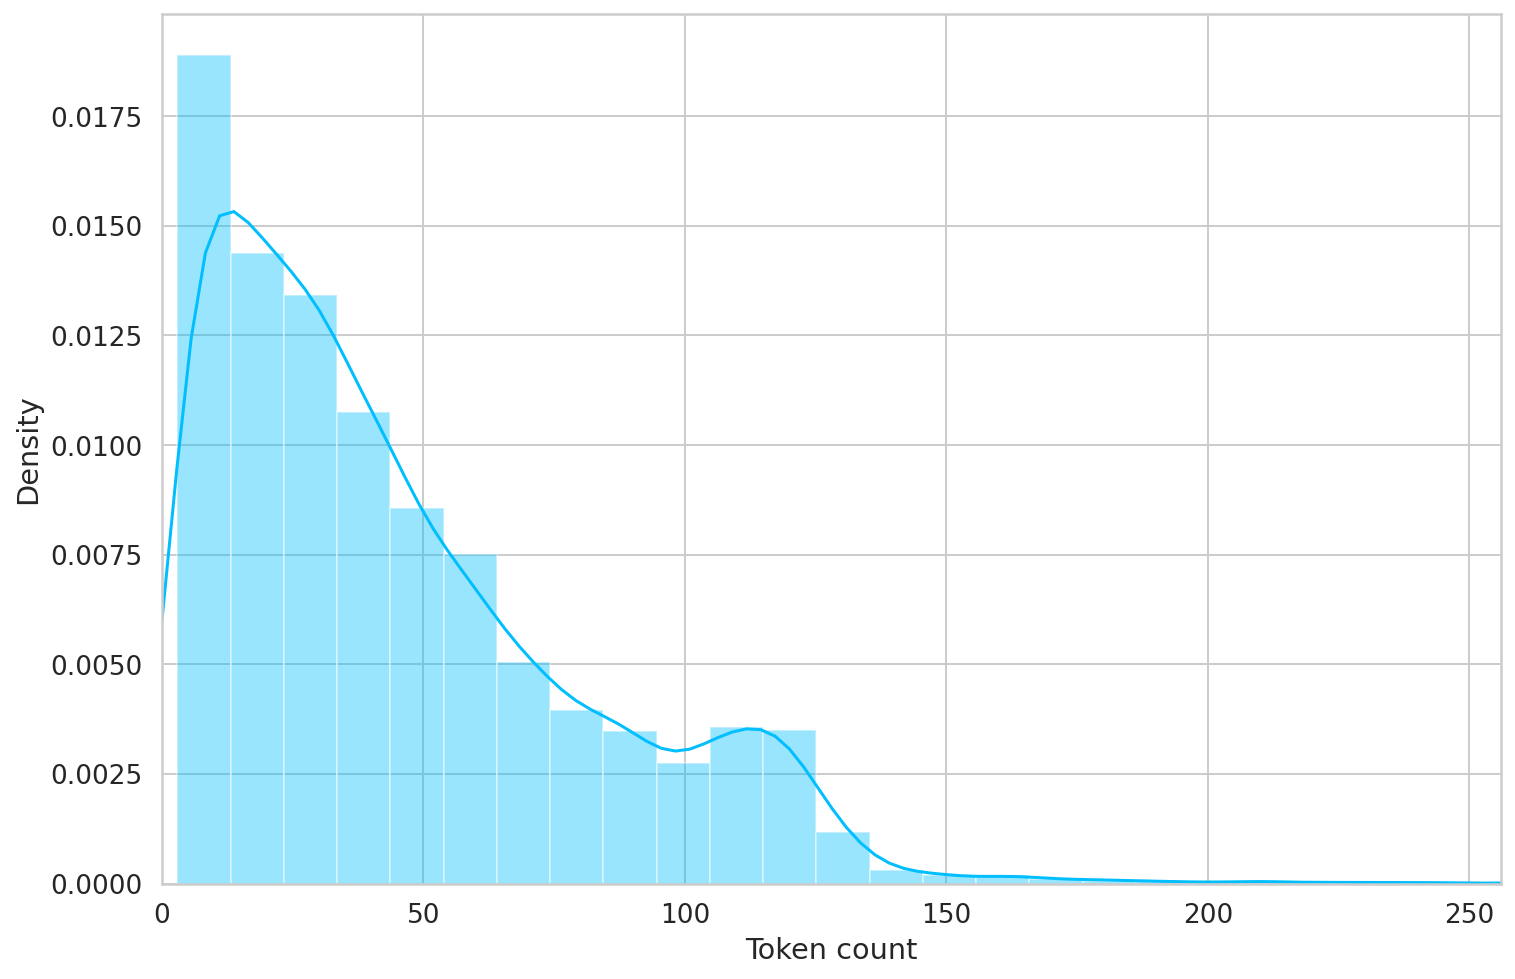

In [ ]:
# 학습 데이터의 모든 댓글들의 길이를 시각화하여 max_length를 선택
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
# 최대 길이의 댓글은 128 token으로 이루어져 있으며, 여유를 두어 max length를 160으로 설정함
MAX_LEN = 160

### PyTorch 프레임워크를 사용해 데이터 셋을 가공하는 함수 작성

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

### 모델 학습을 위한 dataset split


*   Train set
*   Test set
*   Validation set





In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


training data loader의 example batch를 확인

In [ ]:
data = next(iter(train_data_loader))
data.keys()

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

In [ ]:
# Transfer Learning을 위해 Pretrained BERT 다운로드
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

# return_dict = False를 추가해야
# last_hidden_state.shape와 pooled_output.shape 가 실행됨

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape
bert_model.config.hidden_size

768

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2332, 0.4717, 0.2951],
        [0.2219, 0.3612, 0.4168],
        [0.3589, 0.2427, 0.3984],
        [0.2221, 0.3218, 0.4561],
        [0.5762, 0.2056, 0.2181],
        [0.2249, 0.4422, 0.3329],
        [0.2750, 0.3181, 0.4069],
        [0.3732, 0.2454, 0.3813],
        [0.3927, 0.1892, 0.4181],
        [0.3349, 0.1948, 0.4703],
        [0.3043, 0.2263, 0.4695],
        [0.3710, 0.1894, 0.4396],
        [0.2090, 0.4449, 0.3462],
        [0.3396, 0.2594, 0.4010],
        [0.3456, 0.2260, 0.4284],
        [0.1500, 0.3302, 0.5198]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Model Training

In [ ]:
# # EPOCHS = 50
# EPOCHS = 1    # 우선 EPOCH 1을 실행해서 제대로 학습이 되는지 확인 후, 끊기지 않는 서버를 이용해 EPOCH 수를 늘려 학습할 것.

# optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
# total_steps = len(train_data_loader) * EPOCHS

# scheduler = get_linear_schedule_with_warmup(
#   optimizer,
#   num_warmup_steps=0,
#   num_training_steps=total_steps
# )

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)

Fine-tuning을 위해 추천하는 hyperparameters:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

> batch size를 높일 수록 훈련 시간은 줄어들지만, 정확도는 낮아질 것이다. (적절한 batch size를 골라 학습시킬 것)



In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# %%time

# history = defaultdict(list)
# best_accuracy = 0

# for epoch in range(EPOCHS):

#   print(f'Epoch {epoch + 1}/{EPOCHS}')
#   print('-' * 10)

#   train_acc, train_loss = train_epoch(
#     model,
#     train_data_loader,    
#     loss_fn, 
#     optimizer, 
#     device, 
#     scheduler, 
#     len(df_train)
#   )

#   print(f'Train loss {train_loss} accuracy {train_acc}')

#   val_acc, val_loss = eval_model(
#     model,
#     val_data_loader,
#     loss_fn, 
#     device, 
#     len(df_val)
#   )

#   print(f'Val   loss {val_loss} accuracy {val_acc}')
#   print()

#   history['train_acc'].append(train_acc)
#   history['train_loss'].append(train_loss)
#   history['val_acc'].append(val_acc)
#   history['val_loss'].append(val_loss)

#   # best_model_state 저장
#   if val_acc > best_accuracy:
#     torch.save(model.state_dict(), 'best_model_state.bin')
#     best_accuracy = val_acc

In [ ]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1]);

### Pretrained 모델을 사용하는 방법

In [ ]:
# 학습 시간이 너무 오래 걸려서 pt 모델 가져와서 감정분류 진행함
# 학습을 원하는 경우, 위 코드대로 학습시키면 됨

!gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
To: /content/best_model_state.bin
100% 433M/433M [00:01<00:00, 233MB/s]


In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'), strict=False) # strict=False 빼면 오류 발생
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Model Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.883248730964467

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
# 감정 분류 정확도 출력 (모델 성능 출력)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       245
     neutral       0.83      0.85      0.84       254
    positive       0.92      0.93      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



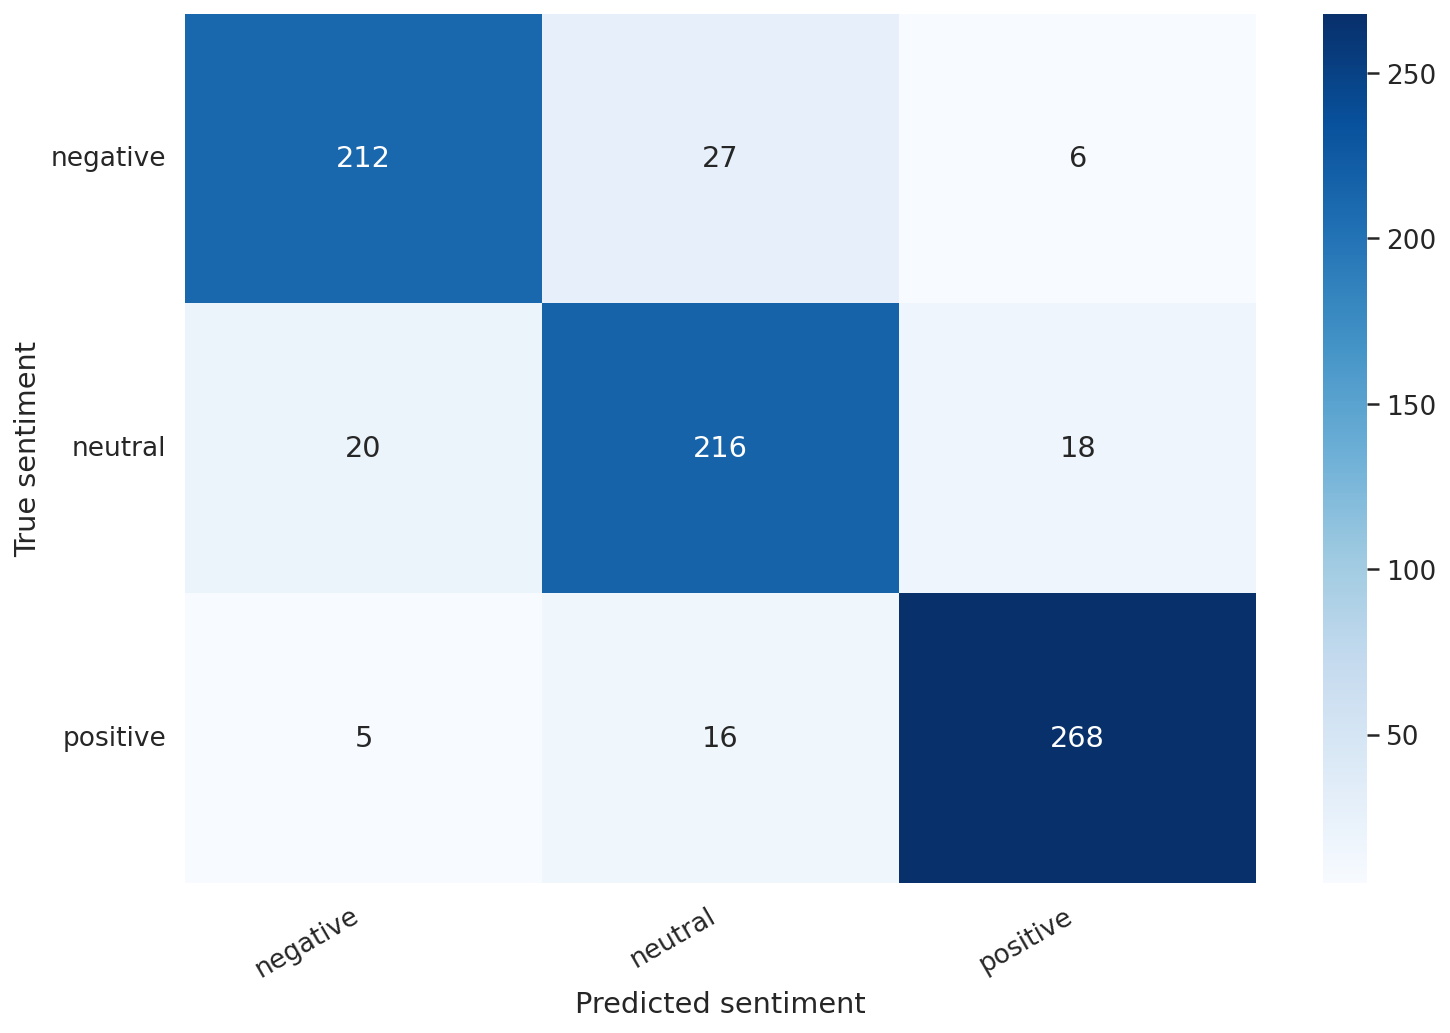

In [ ]:
# 분류 정확도를 시각화
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
# 훈련 및 테스트 결과 예시 출력
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


## 크롤링한 Reddit bitcoin Daily Discussion comments에 대한 감정 분류 진행

In [ ]:
sentiment_result = []

for j in df_comments['comments']:
  review_text = j
  # tokenizer을 사용해 댓글 문장을 encode함
  encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  # print(f'Review text: {review_text}')
  sentiment_result.append(class_names[prediction])
  print(f'Sentiment  : {class_names[prediction]}')

Sentiment  : negative
Sentiment  : neutral
Sentiment  : negative
Sentiment  : positive


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Sentiment  : neutral
Sentiment  : neutral
Sentiment  : negative
Sentiment  : negative
Sentiment  : neutral
Sentiment  : negative
Sentiment  : negative
Sentiment  : negative
Sentiment  : positive
Sentiment  : negative
Sentiment  : negative
Sentiment  : neutral
Sentiment  : neutral
Sentiment  : neutral
Sentiment  : neutral
Sentiment  : negative
Sentiment  : negative
Sentiment  : neutral
Sentiment  : positive
Sentiment  : positive
Sentiment  : neutral
Sentiment  : neutral
Sentiment  : negative
Sentiment  : negative
Sentiment  : positive
Sentiment  : positive
Sentiment  : positive
Sentiment  : neutral
Sentiment  : positive
Sentiment  : negative
Sentiment  : negative
Sentiment  : negative
Sentiment  : positive
Sentiment  : negative
Sentiment  : positive
Sentiment  : positive
Sentiment  : neutral
Sentiment  : positive
Sentiment  : negative
Sentiment  : neutral
Sentiment  : neutral
Sentiment  : positive
Sentiment  : neutral
Sentiment  : negative
Sentiment  : neutral
Sentiment  : neutral
Senti

In [ ]:
sentiment_result

['negative',
 'neutral',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'negative',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'negative',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'negative',
 'negative',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'n

In [ ]:
df_comments.insert(2, 'sentiment', sentiment_result)  # 데이터프레임에 sentiment 결과 추가
df_comments

,date,comments,sentiment
0,2022-05-06,If I go out and buy a $5 wrench and attack mys...,negative
1,2022-05-06,"Please remain seated, seatbelts on, we are exp...",neutral
2,2022-05-06,Didn’t sell a sat.,negative
3,2022-05-06,Holding and bought some extra on top of my dca 🤑,positive
4,2022-05-06,"I've been waiting for BTC to drop, yesterday l...",neutral
...,...,...,...
197,2022-05-06,This daily thread can be so cringe lol,neutral
198,2022-05-06,This sub in a nutshell,positive
199,2022-05-06,>No it doesn't. I'm gonna buy more whatever th...,neutral
200,2022-05-06,I'm not sure to be honest. For a regular Bitco...,neutral


In [ ]:
# 가중치 계산
K_sum = 0   # 가중치 합 저장
neutral_count = 0 # 감정 별 개수 저장
positive_count = 0
negative_count = 0

for s in df_comments['sentiment']:
  if s == 'neutral':    # netural = 0
    K_sum += 0
    neutral_count+=1
  elif s == 'positive':
    K_sum += 1          # positive = 1
    positive_count+=1
  else:               
    K_sum -= 1          # negative = -1
    negative_count+=1

K_weight = K_sum / len(sentiment_result)
K_weight

-0.16336633663366337

In [ ]:
df_comments.insert(3, 'K_weight', K_weight)
df_comments

,date,comments,sentiment,K_weight
0,2022-05-06,If I go out and buy a $5 wrench and attack mys...,negative,-0.163366
1,2022-05-06,"Please remain seated, seatbelts on, we are exp...",neutral,-0.163366
2,2022-05-06,Didn’t sell a sat.,negative,-0.163366
3,2022-05-06,Holding and bought some extra on top of my dca 🤑,positive,-0.163366
4,2022-05-06,"I've been waiting for BTC to drop, yesterday l...",neutral,-0.163366
...,...,...,...,...
197,2022-05-06,This daily thread can be so cringe lol,neutral,-0.163366
198,2022-05-06,This sub in a nutshell,positive,-0.163366
199,2022-05-06,>No it doesn't. I'm gonna buy more whatever th...,neutral,-0.163366
200,2022-05-06,I'm not sure to be honest. For a regular Bitco...,neutral,-0.163366


## CSV 결과 저장 및 댓글 감정 분류에 대한 결과 시각화

In [ ]:
# csv 파일 저장할 경로를 환경에 알맞게 변경하기
import csv
PATH = '/content/drive/MyDrive/Capstone design/긍정부정 분류/Daily sentiment analysis results/'+date+'_result.csv'
df_comments.to_csv(PATH)

In [ ]:
print('neutral 개수: ', neutral_count)
print('\npositive 개수: ', positive_count)
print('negative 개수: ', negative_count)

neutral 개수:  71

positive 개수:  49
negative 개수:  82


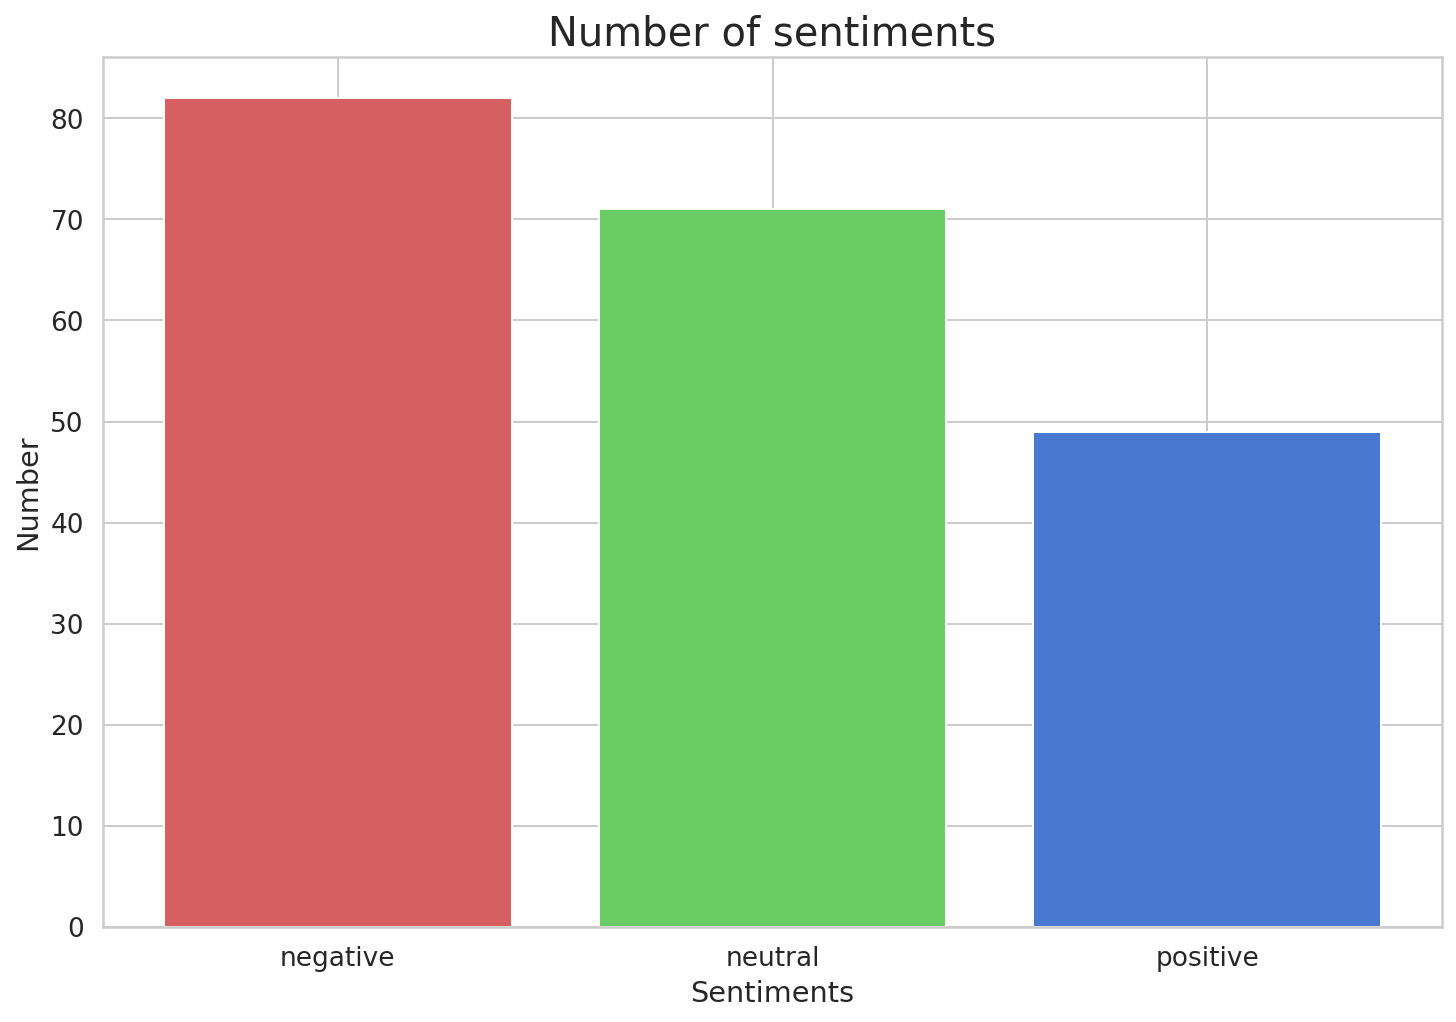

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(3)
sentiments = ['negative', 'neutral', 'positive']
values = [negative_count, neutral_count, positive_count]

plt.bar(x, values, color=['r', 'g', 'b'])
plt.xticks(x, sentiments)
plt.title('Number of sentiments', fontsize=20)
plt.xlabel('Sentiments')
plt.ylabel('Number')

plt.show()